# GITHUB

In [ ]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install yfinance
import yfinance as yf

In [ ]:
import yfinance as yf

# Define the stock ticker and time period
ticker = "SPX"  # Example: Apple Inc.
start_date = "2014-01-01"
end_date = "2024-01-01"

# Fetch historical data
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

# Save to CSV
data.to_csv(f"{ticker}.csv")

[*********************100%***********************]  1 of 1 completed


In [ ]:
import pandas as pd
df = pd.read_csv(f"{ticker}.csv", skiprows=[0, 1])  # Skips first two rows

# Rename columns correctly
df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
# You can adjust the window (here, 14 periods)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
short_ema = df['Close'].ewm(span=12, adjust=False).mean()  # 12-day EMA
long_ema = df['Close'].ewm(span=26, adjust=False).mean()   # 26-day EMA
#Moving Average Convergence Divergence(MACD)
df['MACD'] = short_ema - long_ema  # MACD line
#ewm calcualted exponetial weighted functions
df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df = df.iloc[14:]
df.to_csv(f"{ticker}_test.csv")


In [ ]:
#Official Phase Space Reconstructed Neural ODEs (PSR-NODE or NODE in general)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.model_selection import KFold
import copy
from sklearn.model_selection import TimeSeriesSplit

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),  # 'dim' should match the number of features in your input data
            nn.Tanh(),
            nn.Linear(50, dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func, num_features):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(num_features, 1)  # Adjust to match the number of reconstructed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)

def load_data(file_name):
    data = pd.read_csv(file_name)
    return data[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close', 'MACD', 'Signal Line']]


def phase_space_reconstruction(series, delay, embedding_dim):
    N, num_features = series.shape
    reconstructed = np.zeros((N - (embedding_dim - 1) * delay, embedding_dim * num_features))
    for i in range(num_features):
        for d in range(embedding_dim):
            reconstructed[:, i * embedding_dim + d] = series[d * delay: N - (embedding_dim - d - 1) * delay, i]
    return reconstructed

def preprocess_data(data, delay, embedding_dim, scaler_features=None, scaler_target=None):
    # Separate features and target
    features = data.iloc[:, :-1]  # All columns except 'Close'
    target = data.iloc[:, -1].values.reshape(-1, 1)  # Just the 'Close' column

    # Initialize and fit/transform scalers
    if scaler_features is None:
        scaler_features = MinMaxScaler()
        features = scaler_features.fit_transform(features)
    else:
        features = scaler_features.transform(features)

    if scaler_target is None:
        scaler_target = MinMaxScaler()
        target = scaler_target.fit_transform(target)
    else:
        target = scaler_target.transform(target)

    # Apply phase space reconstruction
    reconstructed_features = phase_space_reconstruction(features, delay, embedding_dim)
    target = target[delay * (embedding_dim - 1):]

    return reconstructed_features, target.squeeze(), scaler_features, scaler_target

def train_neural_ode_with_validation(model, train_data, train_target, val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

# Main execution
file_name = f'{ticker}_test.csv'
raw_data = load_data(file_name)

# Split the raw data into training and testing sets (80% train, 20% test)
split_idx = int(len(raw_data) * 0.8)
train_data, test_data = raw_data[:split_idx], raw_data[split_idx:]

# Preprocess the training data
train_features, train_target, scaler_features, scaler_target = preprocess_data(
    train_data, 1, 3
)

# Determine the number of features in your input data after phase space reconstruction
num_features_reconstructed = train_features.shape[1]

# Initialize your NeuralODE model with the correct number of input features
neural_ode_model = NeuralODEModel(ODEFunc(dim=num_features_reconstructed), num_features_reconstructed)

# Preprocess the test data using the same scalers
test_features, test_target, _, _ = preprocess_data(
    test_data, 1, 3, scaler_features, scaler_target
)

# Ensure the target is in the correct shape for training and testing
train_target = train_target.squeeze()
test_target = test_target.squeeze()

# Number of splits for TimeSeriesSplit
n_splits = 5

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(train_features):
    # Split the data into training and validation sets for each fold
    kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
    kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]

    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, kf_train_features, kf_train_target, kf_val_features, kf_val_target, epochs=100, lr=0.001, patience=10)

    # After training, make predictions on the test set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test_scaled = trained_model(test_tensor).detach().numpy()

# The target values are already scaled, as they come from the preprocessing step
# So there's no need to scale them again, just ensure they are the correct shape
test_target_scaled = test_target.reshape(-1, 1)

# Calculate MAE and RMSE on the scaled test set predictions
mae_scaled = mean_absolute_error(test_target_scaled, forecasted_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(test_target_scaled, forecasted_test_scaled))

print(f"Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}")

Epoch 0, Train Loss: 0.1672053337097168, Val Loss: 0.03455633297562599
Epoch 10, Train Loss: 0.03838843107223511, Val Loss: 0.03027704544365406
Early stopping triggered at epoch 14
Epoch 0, Train Loss: 0.02573314681649208, Val Loss: 0.025810211896896362
Epoch 10, Train Loss: 0.017920592799782753, Val Loss: 0.03028814122080803
Early stopping triggered at epoch 12
Epoch 0, Train Loss: 0.02206563390791416, Val Loss: 0.023502785712480545
Epoch 10, Train Loss: 0.013740228489041328, Val Loss: 0.004422676749527454
Epoch 20, Train Loss: 0.008169218897819519, Val Loss: 0.003988861106336117
Early stopping triggered at epoch 23
Epoch 0, Train Loss: 0.009625027887523174, Val Loss: 0.014884084463119507
Epoch 10, Train Loss: 0.005251292139291763, Val Loss: 0.012074614875018597
Epoch 20, Train Loss: 0.0022233673371374607, Val Loss: 0.009136941283941269
Epoch 30, Train Loss: 0.0015777210937812924, Val Loss: 0.00866337027400732
Epoch 40, Train Loss: 0.0012860524002462626, Val Loss: 0.006309452466666698

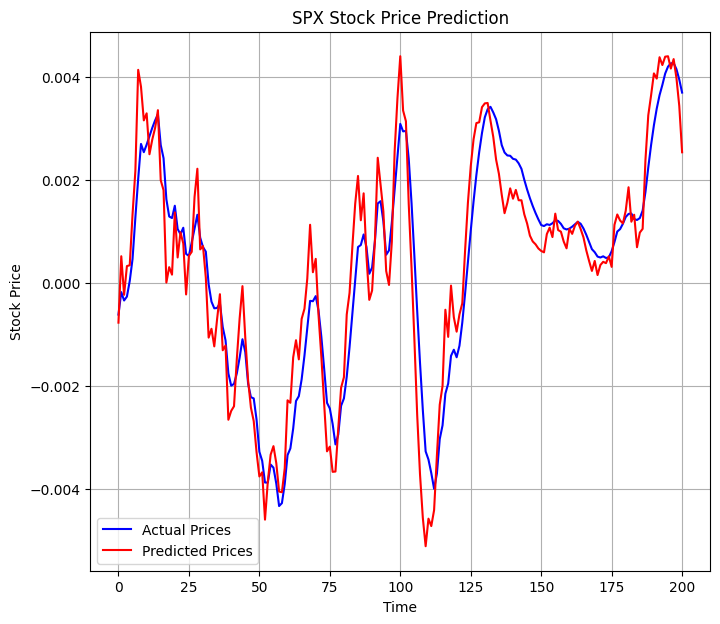

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have 'scaler_target' from your preprocessing step
# Reverse scaling for predicted and actual values
predicted_test_unscaled = scaler_target.inverse_transform(forecasted_test_scaled)
actual_test_unscaled = scaler_target.inverse_transform(test_target_scaled.reshape(-1, 1))

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#NODE on Lorenz
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.model_selection import KFold
import copy
from sklearn.model_selection import TimeSeriesSplit

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),  # 'dim' should match the number of features in your input data
            nn.Tanh(),
            nn.Linear(50, dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func, num_features):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(num_features, 1)  # Adjust to match the number of reconstructed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)

def load_data(file_name):
    data = pd.read_csv(file_name)
    return data[['X', 'Z', 'Y']]


def phase_space_reconstruction(series, delay, embedding_dim):
    N, num_features = series.shape
    reconstructed = np.zeros((N - (embedding_dim - 1) * delay, embedding_dim * num_features))
    for i in range(num_features):
        for d in range(embedding_dim):
            reconstructed[:, i * embedding_dim + d] = series[d * delay: N - (embedding_dim - d - 1) * delay, i]
    return reconstructed

def preprocess_data(data, delay, embedding_dim, scaler_features=None, scaler_target=None):
    # Separate features and target
    features = data.iloc[:, :-1]  # All columns except 'Close'
    target = data.iloc[:, -1].values.reshape(-1, 1)  # Just the 'Close' column

    # Initialize and fit/transform scalers
    if scaler_features is None:
        scaler_features = MinMaxScaler()
        features = scaler_features.fit_transform(features)
    else:
        features = scaler_features.transform(features)

    if scaler_target is None:
        scaler_target = MinMaxScaler()
        target = scaler_target.fit_transform(target)
    else:
        target = scaler_target.transform(target)

    # Apply phase space reconstruction
    reconstructed_features = phase_space_reconstruction(features, delay, embedding_dim)
    target = target[delay * (embedding_dim - 1):]

    return reconstructed_features, target.squeeze(), scaler_features, scaler_target

def train_neural_ode_with_validation(model, train_data, train_target, val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

# Main execution
file_name = 'lorenz.csv'
raw_data = load_data(file_name)

# Split the raw data into training and testing sets (80% train, 20% test)
split_idx = int(len(raw_data) * 0.8)
train_data, test_data = raw_data[:split_idx], raw_data[split_idx:]

# Preprocess the training data
train_features, train_target, scaler_features, scaler_target = preprocess_data(
    train_data, 1, 3
)

# Determine the number of features in your input data after phase space reconstruction
num_features_reconstructed = train_features.shape[1]

# Initialize your NeuralODE model with the correct number of input features
neural_ode_model = NeuralODEModel(ODEFunc(dim=num_features_reconstructed), num_features_reconstructed)

# Preprocess the test data using the same scalers
test_features, test_target, _, _ = preprocess_data(
    test_data, 1, 3, scaler_features, scaler_target
)

# Ensure the target is in the correct shape for training and testing
train_target = train_target.squeeze()
test_target = test_target.squeeze()

# Number of splits for TimeSeriesSplit
n_splits = 5

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(train_features):
    # Split the data into training and validation sets for each fold
    kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
    kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]

    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, kf_train_features, kf_train_target, kf_val_features, kf_val_target, epochs=100, lr=0.001, patience=10)

    # After training, make predictions on the test set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test_scaled = trained_model(test_tensor).detach().numpy()

# The target values are already scaled, as they come from the preprocessing step
# So there's no need to scale them again, just ensure they are the correct shape
test_target_scaled = test_target.reshape(-1, 1)

# Calculate MAE and RMSE on the scaled test set predictions
mae_scaled = mean_absolute_error(test_target_scaled, forecasted_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(test_target_scaled, forecasted_test_scaled))

print(f"Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}")

Epoch 0, Train Loss: 0.014697353355586529, Val Loss: 0.006180368829518557
Epoch 10, Train Loss: 0.009003532119095325, Val Loss: 0.00475860433652997
Epoch 20, Train Loss: 0.0054552145302295685, Val Loss: 0.003971713595092297
Early stopping triggered at epoch 30
Epoch 0, Train Loss: 0.0045768036507070065, Val Loss: 0.013520652428269386
Epoch 10, Train Loss: 0.003962337039411068, Val Loss: 0.009200046770274639
Epoch 20, Train Loss: 0.0037718440871685743, Val Loss: 0.008571485988795757
Epoch 30, Train Loss: 0.003639660542830825, Val Loss: 0.008492191322147846
Epoch 40, Train Loss: 0.003548523411154747, Val Loss: 0.008242250420153141
Epoch 50, Train Loss: 0.0034518030006438494, Val Loss: 0.007970635779201984
Epoch 60, Train Loss: 0.003340679919347167, Val Loss: 0.007707781624048948
Epoch 70, Train Loss: 0.003215785138309002, Val Loss: 0.00738247437402606
Epoch 80, Train Loss: 0.0030731407459825277, Val Loss: 0.007038268260657787
Epoch 90, Train Loss: 0.002909241244196892, Val Loss: 0.006656

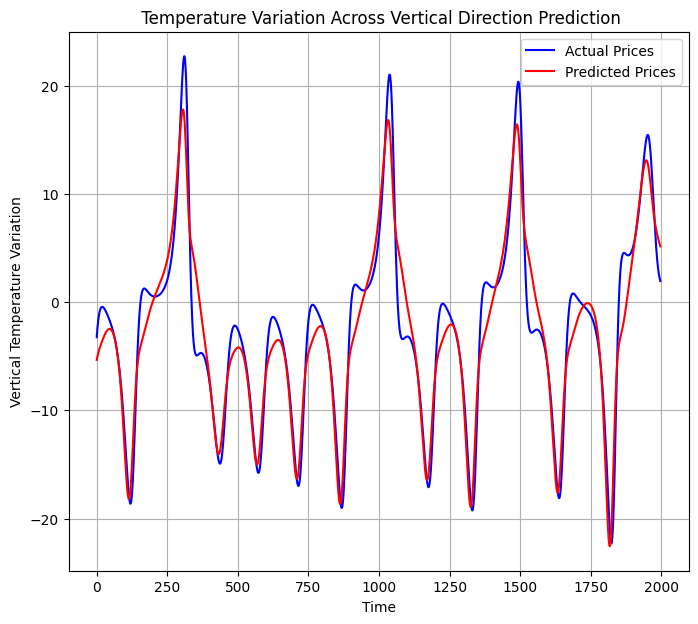

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have 'scaler_target' from your preprocessing step
# Reverse scaling for predicted and actual values
predicted_test_unscaled = scaler_target.inverse_transform(forecasted_test_scaled)
actual_test_unscaled = scaler_target.inverse_transform(test_target_scaled.reshape(-1, 1))

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title(' Temperature Variation Across Vertical Direction Prediction')
plt.xlabel('Time')
plt.ylabel('Vertical Temperature Variation')
plt.legend()
plt.grid(True)
plt.savefig('lorenz.png', dpi=600)
plt.show()

In [ ]:
#NODE on Mackey-Glass
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.model_selection import KFold
import copy
from sklearn.model_selection import TimeSeriesSplit

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),  # 'dim' should match the number of features in your input data
            nn.Tanh(),
            nn.Linear(50, dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func, num_features):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(num_features, 1)  # Adjust to match the number of reconstructed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)

def load_data(file_name):
    data = pd.read_csv(file_name)
    return data[['x_t-15', 'x_t-30' ,'x_t-45', 'x_t']]

def phase_space_reconstruction(series, delay, embedding_dim):
    N, num_features = series.shape
    reconstructed = np.zeros((N - (embedding_dim - 1) * delay, embedding_dim * num_features))
    for i in range(num_features):
        for d in range(embedding_dim):
            reconstructed[:, i * embedding_dim + d] = series[d * delay: N - (embedding_dim - d - 1) * delay, i]
    return reconstructed

def preprocess_data(data, delay, embedding_dim, scaler_features=None, scaler_target=None):
    # Separate features and target
    features = data.iloc[:, :-1]  # All columns except 'Close'
    target = data.iloc[:, -1].values.reshape(-1, 1)  # Just the 'Close' column

    # Initialize and fit/transform scalers
    if scaler_features is None:
        scaler_features = MinMaxScaler()
        features = scaler_features.fit_transform(features)
    else:
        features = scaler_features.transform(features)

    if scaler_target is None:
        scaler_target = MinMaxScaler()
        target = scaler_target.fit_transform(target)
    else:
        target = scaler_target.transform(target)

    # Apply phase space reconstruction
    reconstructed_features = phase_space_reconstruction(features, delay, embedding_dim)
    target = target[delay * (embedding_dim - 1):]

    return reconstructed_features, target.squeeze(), scaler_features, scaler_target

def train_neural_ode_with_validation(model, train_data, train_target, val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

# Main execution
file_name = 'mackey.csv'
raw_data = load_data(file_name)

# Split the raw data into training and testing sets (80% train, 20% test)
split_idx = int(len(raw_data) * 0.8)
train_data, test_data = raw_data[:split_idx], raw_data[split_idx:]

# Preprocess the training data
train_features, train_target, scaler_features, scaler_target = preprocess_data(
    train_data, 1, 3
)

# Determine the number of features in your input data after phase space reconstruction
num_features_reconstructed = train_features.shape[1]

# Initialize your NeuralODE model with the correct number of input features
neural_ode_model = NeuralODEModel(ODEFunc(dim=num_features_reconstructed), num_features_reconstructed)

# Preprocess the test data using the same scalers
test_features, test_target, _, _ = preprocess_data(
    test_data, 1, 3, scaler_features, scaler_target
)

# Ensure the target is in the correct shape for training and testing
train_target = train_target.squeeze()
test_target = test_target.squeeze()

# Number of splits for TimeSeriesSplit
n_splits = 5

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(train_features):
    # Split the data into training and validation sets for each fold
    kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
    kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]

    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, kf_train_features, kf_train_target, kf_val_features, kf_val_target, epochs=100, lr=0.001, patience=10)

    # After training, make predictions on the test set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test_scaled = trained_model(test_tensor).detach().numpy()

# The target values are already scaled, as they come from the preprocessing step
# So there's no need to scale them again, just ensure they are the correct shape
test_target_scaled = test_target.reshape(-1, 1)

# Calculate MAE and RMSE on the scaled test set predictions
mae_scaled = mean_absolute_error(test_target_scaled, forecasted_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(test_target_scaled, forecasted_test_scaled))

print(f"Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}")

Epoch 0, Train Loss: 0.11756371706724167, Val Loss: 0.09772278368473053
Epoch 10, Train Loss: 0.049660101532936096, Val Loss: 0.05184362083673477
Epoch 20, Train Loss: 0.037996403872966766, Val Loss: 0.03898240998387337
Epoch 30, Train Loss: 0.03642449900507927, Val Loss: 0.03681807965040207
Epoch 40, Train Loss: 0.034304723143577576, Val Loss: 0.035000357776880264
Epoch 50, Train Loss: 0.032770875841379166, Val Loss: 0.03352872282266617
Epoch 60, Train Loss: 0.03170309215784073, Val Loss: 0.032403476536273956
Epoch 70, Train Loss: 0.0306916031986475, Val Loss: 0.031343329697847366
Epoch 80, Train Loss: 0.029673879966139793, Val Loss: 0.030298272147774696
Epoch 90, Train Loss: 0.02865937538444996, Val Loss: 0.02925742045044899
Epoch 0, Train Loss: 0.027983279898762703, Val Loss: 0.02408088743686676
Epoch 10, Train Loss: 0.02480703964829445, Val Loss: 0.021630752831697464
Epoch 20, Train Loss: 0.02213028445839882, Val Loss: 0.01962895505130291
Epoch 30, Train Loss: 0.02016589045524597, 

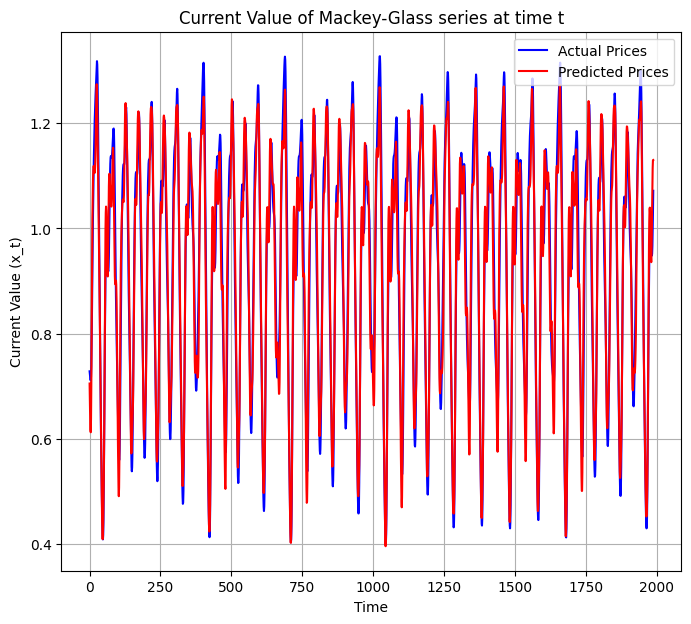

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have 'scaler_target' from your preprocessing step
# Reverse scaling for predicted and actual values
predicted_test_unscaled = scaler_target.inverse_transform(forecasted_test_scaled)
actual_test_unscaled = scaler_target.inverse_transform(test_target_scaled.reshape(-1, 1))

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title('Current Value of Mackey-Glass series at time t')
plt.xlabel('Time')
plt.ylabel('Current Value (x_t)')
plt.legend()
plt.grid(True)
plt.savefig('mackey.png', dpi=600)
plt.show()

# Old Stuff - Learning

INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cpu


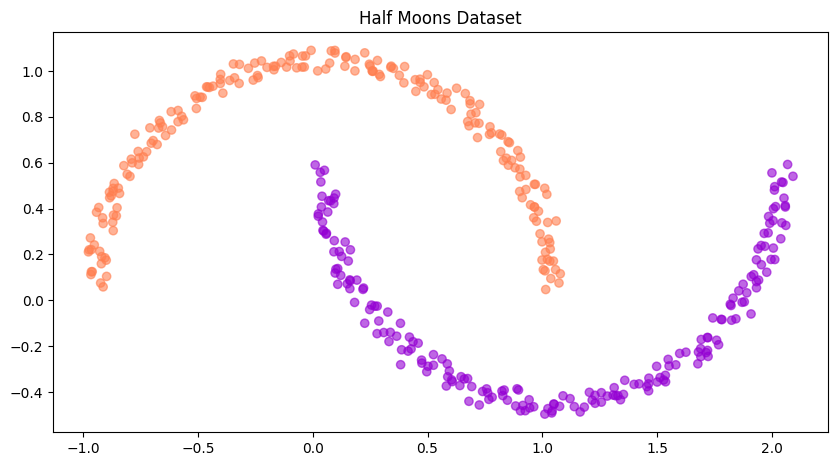

In [ ]:
%matplotlib inline
import time
import logging
import statistics
from typing import Optional, List

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import Dataset

try:
    import torchdiffeq
except ModuleNotFoundError:
    !pip install --quiet torchdiffeq
    import torchdiffeq

try:
    import rich
except ModuleNotFoundError:
    !pip install --quiet rich
    import rich

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from torchmetrics.classification import Accuracy

pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

class MoonsDataset(Dataset):
    """Half Moons Classification Dataset

    Adapted from https://github.com/DiffEqML/torchdyn
    """
    def __init__(self, num_samples=100, noise_std=1e-4):
        self.num_samples = num_samples
        self.noise_std = noise_std
        self.X, self.y = self.generate_moons(num_samples, noise_std)

    @staticmethod
    def generate_moons(num_samples=100, noise_std=1e-4):
        """Creates a *moons* dataset of `num_samples` data points.
        :param num_samples: number of data points in the generated dataset
        :type num_samples: int
        :param noise_std: standard deviation of noise magnitude added to each data point
        :type noise_std: float
        """
        num_samples_out = num_samples // 2
        num_samples_in = num_samples - num_samples_out
        theta_out = np.linspace(0, np.pi, num_samples_out)
        theta_in = np.linspace(0, np.pi, num_samples_in)
        outer_circ_x = np.cos(theta_out)
        outer_circ_y = np.sin(theta_out)
        inner_circ_x = 1 - np.cos(theta_in)
        inner_circ_y = 1 - np.sin(theta_in) - 0.5

        X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                       np.append(outer_circ_y, inner_circ_y)]).T
        y = np.hstack([np.zeros(num_samples_out), np.ones(num_samples_in)])

        if noise_std is not None:
            X += noise_std * np.random.rand(num_samples, 2)

        X = torch.Tensor(X)
        y = torch.LongTensor(y)
        return X, y

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def plot_binary_classification_dataset(X, y, title=None):
    CLASS_COLORS = ['coral', 'darkviolet']
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X[:, 0], X[:, 1], color=[CLASS_COLORS[yi.int()] for yi in y], alpha=0.6)
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)

    return fig, ax

sample_dataset = MoonsDataset(num_samples=400, noise_std=1e-1)
fig, ax = plot_binary_classification_dataset(sample_dataset.X, sample_dataset.y, title='Half Moons Dataset')

In [ ]:
def split_dataset(dataset_size:int, split_percentages:List[float]) -> List[int]:
    split_sizes = [int(pi * dataset_size) for pi in split_percentages]
    split_sizes[0] += dataset_size - sum(split_sizes)
    return split_sizes


class ToyDataModule(pl.LightningDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__()
        self.dataset_size = dataset_size
        if split_percentages is None:
            split_percentages = [0.8, 0.1, 0.1]
        self.split_sizes = split_dataset(self.dataset_size, split_percentages)

    def prepare_data(self):
        pass

    def setup(self, stage: Optional[str] = None):
        pass

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_set, batch_size=len(self.train_set), shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(self.val_set, batch_size=len(self.val_set), shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(self.test_set, batch_size=len(self.test_set), shuffle=False)
        return test_loader


class HalfMoonsDataModule(ToyDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__(dataset_size, split_percentages=split_percentages)

    def setup(self, stage: Optional[str] = None):
        dataset = MoonsDataset(num_samples=self.dataset_size, noise_std=1e-1)
        self.train_set, self.val_set, self.test_set = torch.utils.data.random_split(dataset, self.split_sizes)

In [ ]:
class _ODEFunc(nn.Module):
    def __init__(self, module, autonomous=True):
        super().__init__()
        self.module = module
        self.autonomous = autonomous

    def forward(self, t, x):
        if not self.autonomous:
            x = torch.cat([torch.ones_like(x[:, [0]]) * t, x], 1)
        return self.module(x)


class ODEBlock(nn.Module):
    def __init__(self, odefunc: nn.Module, solver: str = 'dopri5',
                 rtol: float = 1e-4, atol: float = 1e-4, adjoint: bool = True,
                 autonomous: bool = True):
        super().__init__()
        self.odefunc = _ODEFunc(odefunc, autonomous=autonomous)
        self.rtol = rtol
        self.atol = atol
        self.solver = solver
        self.use_adjoint = adjoint
        self.integration_time = torch.tensor([0, 1], dtype=torch.float32)

    @property
    def ode_method(self):
        return torchdiffeq.odeint_adjoint if self.use_adjoint else torchdiffeq.odeint

    def forward(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        integration_time = self.integration_time if integration_time is None else integration_time
        integration_time = integration_time.to(x.device)
        ode_method =  torchdiffeq.odeint_adjoint if adjoint else torchdiffeq.odeint
        out = ode_method(
            self.odefunc, x, integration_time, rtol=self.rtol,
            atol=self.atol, method=self.solver)
        return out

In [ ]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, t_span:torch.Tensor, learning_rate:float=5e-3):
        super().__init__()
        self.model = model
        self.t_span = t_span
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def inference(self, x, time_span):
        return self.model(x, adjoint=False, integration_time=time_span)

    def inference_no_projection(self, x, time_span):
        return self.model.forward_no_projection(x, adjoint=False, integration_time=time_span)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        y_pred = y_pred[-1]  # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        y_pred = y_pred[-1]  # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        acc = self.accuracy(y_pred.softmax(dim=-1), y)
        self.log('val_accuracy', acc, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        y_pred = y_pred[-1]  # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        acc = self.accuracy(y_pred.softmax(dim=-1), y)
        self.log('test_accuracy', acc, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

In [ ]:
adjoint = True
data_module = HalfMoonsDataModule(1000)
t_span = torch.linspace(0, 1, 2)
f = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 2))
model = ODEBlock(f, adjoint=adjoint)
learner = Learner(model, t_span)

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(mode="max", monitor="val_accuracy"),
        pl.callbacks.RichProgressBar(),
    ],
    log_every_n_steps=1,
)
trainer.fit(learner, datamodule=data_module)
val_result = trainer.validate(learner, datamodule=data_module, verbose=True)
test_result = trainer.test(learner, datamodule=data_module, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model    │ ODEBlock           │    322 │ train │
│ 1 │ accuracy │ MulticlassAccuracy │      0 │ train │
└───┴──────────┴────────────────────┴────────┴───────┘

Trainable params: 322                                                                                              
Non-trainable params: 0                                                                                            
Total params: 322                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │            1.0            │
│         val_loss          │   0.001368509721942246    │
└───────────────────────────┴───────────────────────────┘

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            1.0            │
│         test_loss         │   0.0016214463394135237   │
└───────────────────────────┴───────────────────────────┘

In [ ]:
@torch.no_grad()
def run_inference(learner, data_loader, time_span):
    learner.to(device)
    trajectories = []
    classes = []
    time_span = torch.from_numpy(time_span).to(device)
    for data, target in data_loader:
        data = data.to(device)
        traj = learner.inference(data, time_span).cpu().numpy()
        trajectories.append(traj)
        classes.extend(target.numpy())
    trajectories = np.concatenate(trajectories, 1)
    return trajectories, classes

time_span = np.linspace(0.0, 1.0, 100)
trajectories, classes = run_inference(learner, data_module.train_dataloader(), time_span)

colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

In [ ]:
#@title You can omit reading this piece of code.

def plot_trajectories(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(12,6))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    for i in range(trajectories.shape[1]):
        ax0.plot(time_span, trajectories[:, i, 0], color=class_colors[i], alpha=0.1)
        ax1.plot(time_span, trajectories[:, i, 1], color=class_colors[i], alpha=0.1)

    ax0.set_xlabel(r"$t$ [Depth]")
    ax0.set_ylabel(r"$\mathbf{z}_0(t)$")
    ax0.set_title("Dimension 0")
    ax1.set_xlabel(r"$t$ [Depth]")
    ax1.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax1.set_title("Dimension 1")


def plot_trajectories_3d(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], time_span,
                color=class_colors[i], alpha=0.1)

    ax.set_title('3D Trajectories')
    ax.set_xlabel(r"$\mathbf{z}_0(t)$")
    ax.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax.set_zlabel(r"$t$")


def plot_trajectories_animation(time_span, trajectories, colors, classes, lim=10.0):
    def animate_frame(t):
        ax.cla()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_title('Trajectories')
        ax.set_xlabel(r"$\mathbf{z}_0(t)$")
        ax.set_ylabel(r"$\mathbf{z}_1(t)$")

        zero_classes = np.array(classes) == 0
        one_classes = np.array(classes) == 1

        scatter_zero = ax.plot(
            trajectories[t, zero_classes, 0], trajectories[t, zero_classes, 1],
            'o', color=colors[0], alpha=0.2+0.8*t/len(time_span))
        scatter_one = ax.plot(
            trajectories[t, one_classes, 0], trajectories[t, one_classes, 1],
            'o', color=colors[1], alpha=0.2+0.8*t/len(time_span))
        return scatter_zero, scatter_one

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    anim = FuncAnimation(fig, animate_frame, frames=len(time_span))
    plt.close(fig)
    return anim


def plot_augmented_trajectories_animation(time_span, trajectories, colors, classes, lim=10.0):
    def animate_frame(t):
        ax.cla()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_zlim(-lim, lim)
        ax.set_title('Trajectories')
        ax.set_xlabel(r"$\mathbf{z}_0(t)$")
        ax.set_ylabel(r"$\mathbf{z}_1(t)$")
        ax.set_zlabel(r"$\mathbf{z}_2(t)$")

        zero_classes = np.array(classes) == 0
        one_classes = np.array(classes) == 1

        scatter_zero = ax.plot(
            trajectories[t, zero_classes, 0], trajectories[t, zero_classes, 1], trajectories[t, zero_classes, 2],
            'o', color=colors[0], alpha=0.2+0.8*t/len(time_span))
        scatter_one = ax.plot(
            trajectories[t, one_classes, 0], trajectories[t, one_classes, 1], trajectories[t, one_classes, 2],
            'o', color=colors[1], alpha=0.2+0.8*t/len(time_span))
        return scatter_zero, scatter_one

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    anim = FuncAnimation(fig, animate_frame, frames=len(time_span))
    plt.close(fig)
    return anim


def plot_state_space(trajectories, class_colors, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)

    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1],
                color=class_colors[i], alpha=0.1)

    ax.set_title('State-Space Diagram')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")


def plot_augmented_state_space(trajectories, class_colors, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], trajectories[:, i, 2],
                color=class_colors[i], alpha=0.1)

    ax.set_title('State-Space Diagram')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_zlabel(r"$z$")


def plot_static_vector_field(model, trajectory, N=50, device='cpu', ax=None):
    X, Y = np.mgrid[trajectory[..., 0].min():trajectory[..., 0].max():N*1j,
                    trajectory[..., 1].min():trajectory[..., 1].max():N*1j]
    X = X.T
    Y = Y.T
    P = np.vstack([X.ravel(), Y.ravel()]).T
    P = torch.Tensor(P).to(device)

    with torch.no_grad():
        vector_field = model.odefunc(0.0, P).cpu()
    vector_norm = vector_field.norm(dim=1).view(N, N).numpy()

    vector_field = vector_field.view(N, N, 2).numpy()

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
    ax.contourf(X, Y, vector_norm, cmap='RdYlBu')
    ax.streamplot(X, Y, vector_field[:, :, 0], vector_field[:, :, 1], color='k')

    ax.set_xlim([X.min(), X.max()])
    ax.set_ylim([Y.min(), Y.max()])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title("Learned Vector Field")

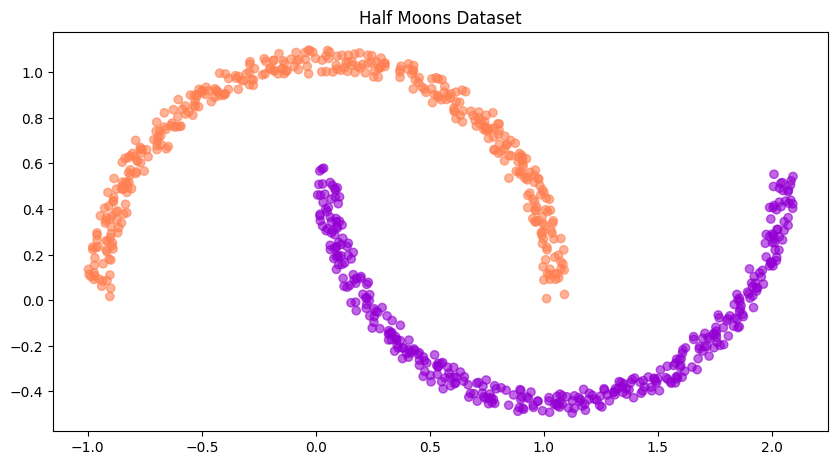

In [ ]:
fig, ax = plot_binary_classification_dataset(*data_module.train_set[:], title='Half Moons Dataset')

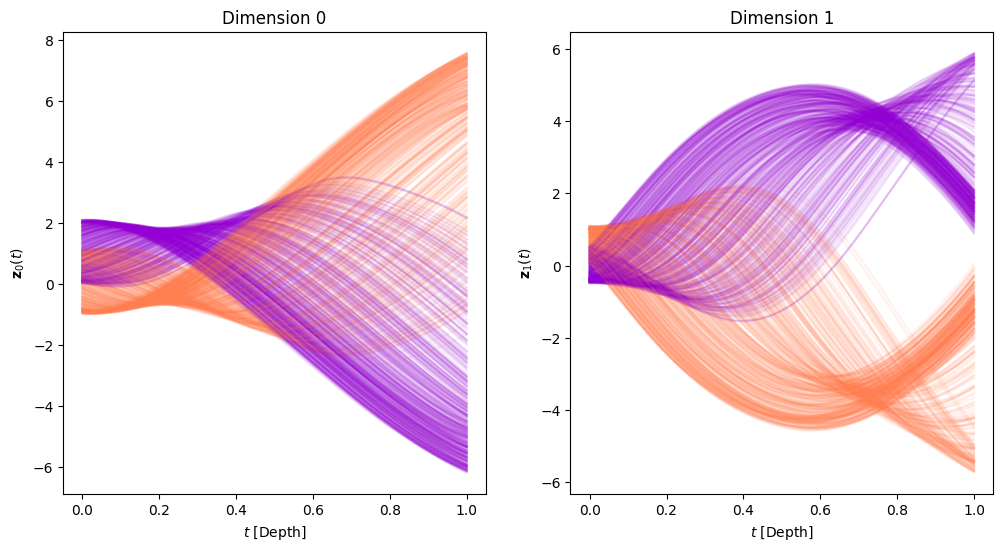

In [ ]:
plot_trajectories(time_span, trajectories, class_colors)

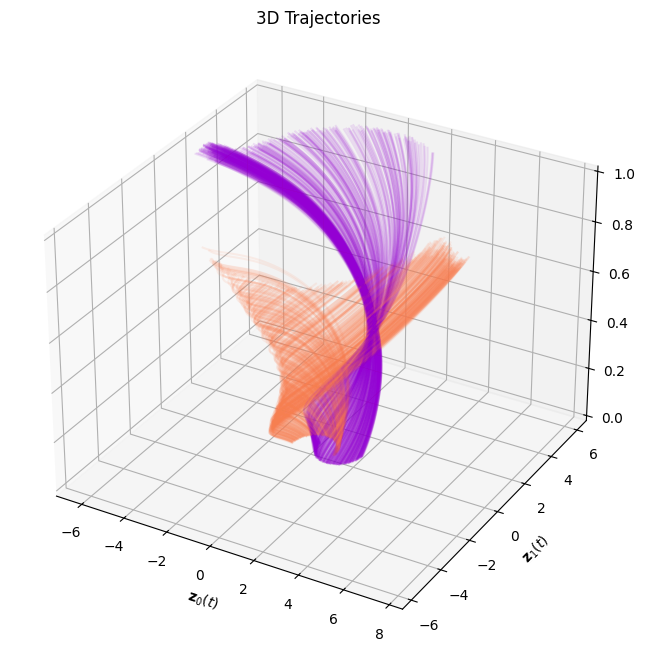

In [ ]:
plot_trajectories_3d(time_span, trajectories, class_colors)

In [ ]:
anim = plot_trajectories_animation(time_span, trajectories, colors, classes, lim=8.0)
HTML(anim.to_html5_video())

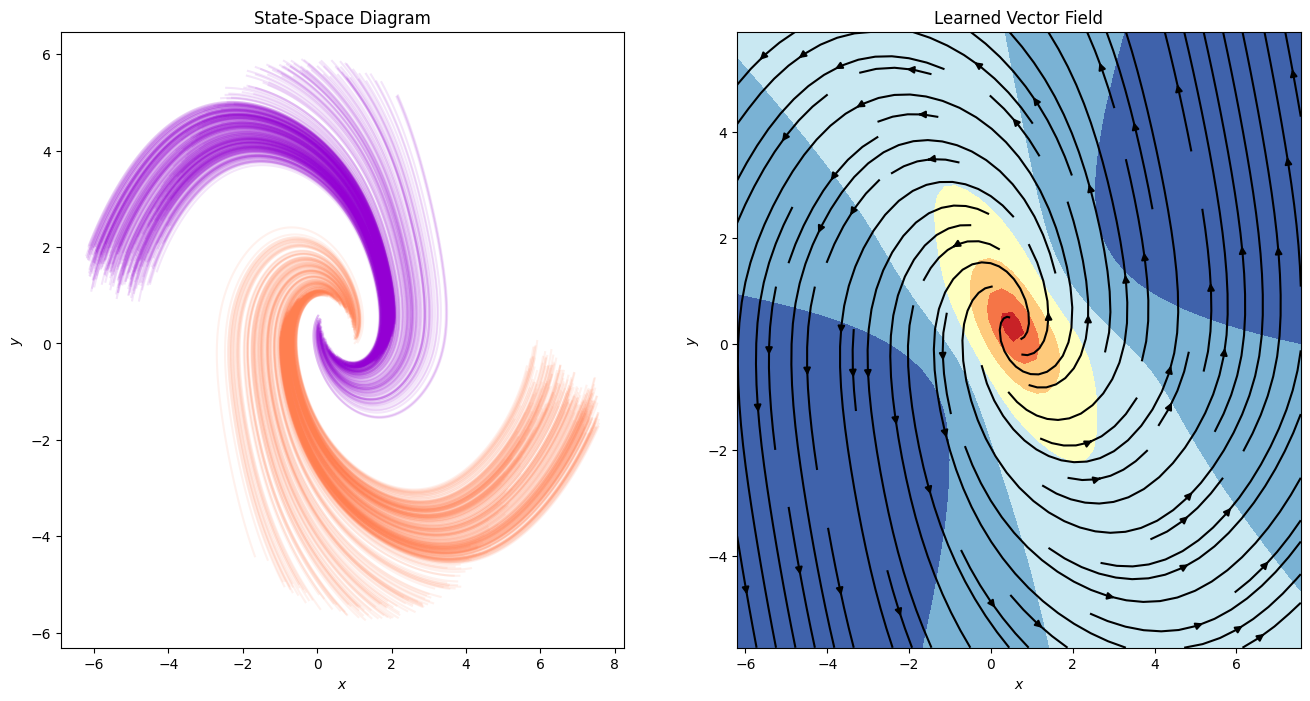

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_state_space(trajectories, class_colors, ax=ax[0])
plot_static_vector_field(model, trajectories, ax=ax[1], device=device)